Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function

This is done with PCE.

In [1]:
# Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function
# This is done with PCE.
import os
import easyvvuq as uq
import chaospy as cp
import pickle
import numpy as np
import matplotlib.pylab as plt
import time
import pandas as pd

In [2]:
np.__version__

'1.19.4'

In [3]:
# Define the Ishigami function
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.
    From https://openturns.github.io/openturns/master/examples/meta_modeling/chaos_ishigami.html
    '''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2,
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var,
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

Ishigami_a = 7.0
Ishigami_b = 0.1
exact = ishigamiSA(Ishigami_a, Ishigami_b)

In [4]:
# define a model to run the Ishigami code directly from python, expecting a dictionary and returning a dictionary
def run_ishigami_model(input):
    import Ishigami
    qois = ["Ishigami"]
    del input['out_file']
    return {qois[0]: Ishigami.evaluate(**input)}

In [5]:
# Define parameter space
def define_params():
    return {
        "x1":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x2":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x3":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "a":        {"type": "float",   "min": Ishigami_a, "max": Ishigami_a, "default": Ishigami_a},
        "b":        {"type": "float",   "min": Ishigami_b, "max": Ishigami_b, "default": Ishigami_b},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

In [6]:
# Define parameter space
def define_vary():
    return {
        "x1":   cp.Uniform(-np.pi, np.pi),
        "x2":   cp.Uniform(-np.pi, np.pi),
        "x3":   cp.Uniform(-np.pi, np.pi)
    }

In [7]:
# Set up and run a campaign
def run_campaign(pce_order=2, use_files=False):

    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start

    # Set up a fresh campaign called "Ishigami_pce."
    my_campaign = uq.Campaign(name='Ishigami_pce.')

    # Create an encoder and decoder for PCE test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='Ishigami.template',
                                             delimiter='$',
                                             target_filename='Ishigami_in.json')

        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["Ishigami"])

        execute = uq.actions.ExecuteLocal('python3 %s/Ishigami.py Ishigami_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory('/tmp'), 
                          uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model))

    # Add the app (automatically set as current app)
    my_campaign.add_app(name="Ishigami", params=define_params(), actions=actions)

    # Create the sampler
    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    my_campaign.set_sampler(uq.sampling.PCESampler(vary=define_vary(), polynomial_order=pce_order))

    # Will draw all (of the finite set of samples)
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Run the cases
    my_campaign.execute(sequential=True).collate()

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Get the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    results = my_campaign.analyse(qoi_cols=["Ishigami"])
    
    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    pickle.dump(results, open('Ishigami_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    times[0] = time_end - time_start_whole

    return results_df, results, times, pce_order, my_campaign.get_active_sampler().count

In [8]:
# Calculate the polynomial chaos expansion for a range of orders

R = {}
for pce_order in range(1, 21):
    R[pce_order] = {}
    (R[pce_order]['results_df'], 
     R[pce_order]['results'], 
     R[pce_order]['times'], 
     R[pce_order]['order'], 
     R[pce_order]['number_of_samples']) = run_campaign(pce_order=pce_order, use_files=False)

Time for phase 1 = 0.029
Number of samples = 8
Time for phase 2 = 0.043
Time for phase 3 = 0.009
Time for phase 4 = 0.002
Time for phase 5 = 0.025
Time for phase 6 = 0.001
Time for phase 1 = 0.009
Number of samples = 27
Time for phase 2 = 0.062
Time for phase 3 = 0.010
Time for phase 4 = 0.002
Time for phase 5 = 0.104
Time for phase 6 = 0.001
Time for phase 1 = 0.009
Number of samples = 64
Time for phase 2 = 0.095
Time for phase 3 = 0.020
Time for phase 4 = 0.003
Time for phase 5 = 0.155
Time for phase 6 = 0.001
Time for phase 1 = 0.010
Number of samples = 125
Time for phase 2 = 0.140
Time for phase 3 = 0.033
Time for phase 4 = 0.004
Time for phase 5 = 0.289
Time for phase 6 = 0.001
Time for phase 1 = 0.009
Number of samples = 216
Time for phase 2 = 0.199
Time for phase 3 = 0.053
Time for phase 4 = 0.005
Time for phase 5 = 0.465
Time for phase 6 = 0.001
Time for phase 1 = 0.009
Number of samples = 343
Time for phase 2 = 0.271
Time for phase 3 = 0.128
Time for phase 4 = 0.007
Time for p

In [9]:
# save the results

pickle.dump(R, open('collected_results.pickle','bw'))

In [10]:
# produce a table of the time taken for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: running the cases
#   4: calculation of statistics including Sobols
#   5: returning of analysed results
#   6: saving campaign and pickled results

Timings = pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
             columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6'], 
             index=[R[r]['order'] for r in list(R.keys())])
Timings.to_csv(open('Timings.csv', 'w'))
display(Timings)

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6
1,0.108155,0.028850,0.042564,0.008517,0.002420,0.024710,0.000794
2,0.187844,0.008870,0.062112,0.010041,0.002037,0.103790,0.000755
3,0.282534,0.009033,0.095379,0.019561,0.002842,0.154769,0.000713
4,0.476469,0.009620,0.139844,0.032664,0.003741,0.289456,0.000777
5,0.731870,0.008610,0.199434,0.052853,0.004667,0.464959,0.000927
6,1.165786,0.009014,0.270912,0.128442,0.006624,0.749515,0.000941
7,1.749857,0.008999,0.364560,0.116643,0.009746,1.248257,0.001133
8,2.555733,0.008764,0.474749,0.162204,0.011895,1.896592,0.001233
9,4.021366,0.012978,0.659705,0.226456,0.015589,3.104717,0.001627
10,6.172589,0.008159,0.775589,0.351347,0.019592,5.015851,0.001753


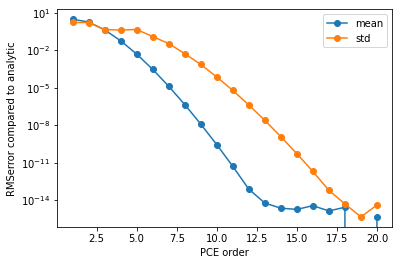

In [11]:
# plot the convergence of the mean and standard deviation to that of the highest order

mean_analytic = exact['expectation']
std_analytic = np.sqrt(exact['variance'])

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'mean') - mean_analytic) for o in O],
             'o-', label='mean')
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'std') - std_analytic) for o in O],
             'o-', label='std')
plt.xlabel('PCE order')
plt.ylabel('RMSerror compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_mean_std.png')
plt.savefig('Convergence_mean_std.pdf')

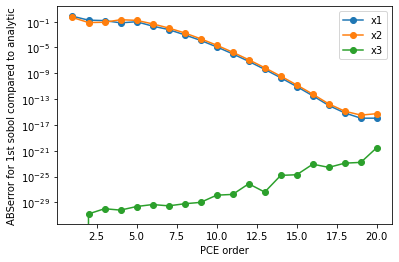

In [12]:
# plot the convergence of the first sobol to that of the highest order

sobol_first_exact = {'x1': exact['S1'], 'x2': exact['S2'], 'x3': exact['S3']}

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_first('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [np.abs(R[o]['results'].sobols_first('Ishigami')[v] - sobol_first_exact[v]) for o in O],
                 'o-',
                 label=v)
plt.xlabel('PCE order')
plt.ylabel('ABSerror for 1st sobol compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_sobol_first.png')
plt.savefig('Convergence_sobol_first.pdf')

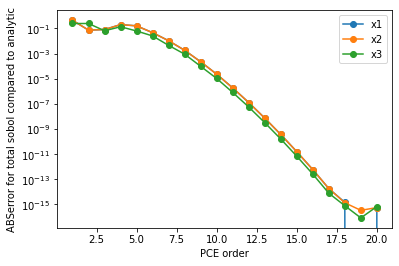

In [13]:
# plot the convergence of the total sobol to that of the highest order

sobol_total_exact = {'x1': exact['ST1'], 'x2': exact['ST2'], 'x3': exact['ST3']}

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_total('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [np.abs(R[o]['results'].sobols_total('Ishigami')[v] - sobol_total_exact[v]) for o in O],
                 'o-',
                 label=v)
plt.xlabel('PCE order')
plt.ylabel('ABSerror for total sobol compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_sobol_total.png')
plt.savefig('Convergence_sobol_total.pdf')

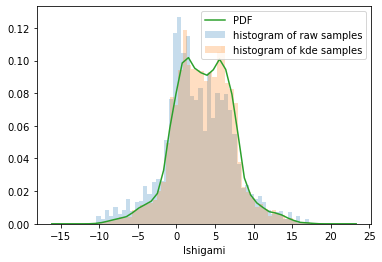

In [14]:
# Plot the distribution function

results_df = R[O[-1]]['results_df']
results = R[O[-1]]['results']
Ishigami_dist = results.raw_data['output_distributions']['Ishigami']

plt.figure()
plt.hist(results_df.Ishigami[0], density=True, bins=50, label='histogram of raw samples', alpha=0.25)
if hasattr(Ishigami_dist, 'samples'):
    plt.hist(Ishigami_dist.samples[0], density=True, bins=50, label='histogram of kde samples', alpha=0.25)
t1 = Ishigami_dist[0]
plt.plot(np.linspace(t1.lower, t1.upper), t1.pdf(np.linspace(t1.lower,t1.upper)), label='PDF')
plt.legend(loc=0)
plt.xlabel('Ishigami')
plt.savefig('Ishigami_distribution_function.png')

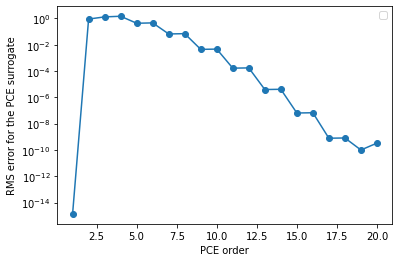

In [15]:
# plot the RMS surrogate error at the PCE vary points
_o = []
_RMS = []
for r in R.values():
    results_df = r['results_df']
    results = r['results']
    Ishigami_surrogate = np.squeeze(np.array(results.surrogate()(results_df[results.inputs])['Ishigami']))
    Ishigami_samples = np.squeeze(np.array(results_df['Ishigami']))
    _RMS.append((np.sqrt((((Ishigami_surrogate - Ishigami_samples))**2).mean())))
    _o.append(r['order'])

plt.figure()
plt.semilogy(_o, _RMS, 'o-')
plt.xlabel('PCE order')
plt.ylabel('RMS error for the PCE surrogate')
plt.legend(loc=0)
plt.savefig('Convergence_surrogate.png')
plt.savefig('Convergence_surrogate.pdf')

In [19]:
# prepare the test data
test_campaign = uq.Campaign(name='Ishigami.')        
test_campaign.add_app(name="Ishigami", params=define_params(), 
                      actions=uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model)))
test_campaign.set_sampler(uq.sampling.quasirandom.LHCSampler(vary=define_vary(), count=100))
test_campaign.execute(nsamples=1000, sequential=True).collate()
test_df = test_campaign.get_collation_result()

In [17]:
# calculate the PCE surrogates
test_points = test_df[test_campaign.get_active_sampler().vary.get_keys()]
test_results = np.squeeze(test_df['Ishigami'].values)
test_predictions = {}
for i in list(R.keys()):
    test_predictions[i] = np.squeeze(np.array(R[i]['results'].surrogate()(test_points)['Ishigami']))

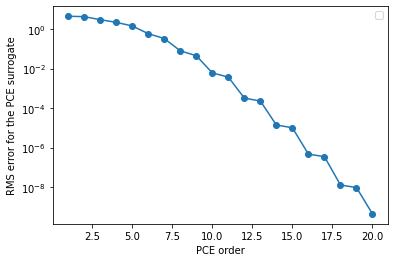

In [18]:
# plot the convergence of the surrogate
_o = []
_RMS = []
for r in R.values():
    _RMS.append((np.sqrt((((test_predictions[r['order']] - test_results))**2).mean())))
    _o.append(r['order'])

plt.figure()
plt.semilogy(_o, _RMS, 'o-')
plt.xlabel('PCE order')
plt.ylabel('RMS error for the PCE surrogate')
plt.legend(loc=0)
plt.savefig('Convergence_PCE_surrogate.png')
plt.savefig('Convergence_PCE_surrogate.pdf')